In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Part I. EDA of user logins

# Importing data and basic data wrangling

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


As shown, there is no missing values, but some duplicated timestamps, especiallly there are 3 entries of the same timestamp of "1970-02-24 23:09:57". Without further information on how the data was collected and how frequently a user can login to their account , it's hard to say if these duplicated entries are valid or not. For the following analysis, we will treat them as valid entries.

In [6]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [7]:
logins['login_time']

0       1970-01-01 20:13:18
1       1970-01-01 20:16:10
2       1970-01-01 20:16:37
3       1970-01-01 20:16:36
4       1970-01-01 20:26:21
                ...        
93137   1970-04-13 18:50:19
93138   1970-04-13 18:43:56
93139   1970-04-13 18:54:02
93140   1970-04-13 18:57:38
93141   1970-04-13 18:54:23
Name: login_time, Length: 93142, dtype: datetime64[ns]

In [8]:
# convert 'login_time' column as date and time format and sort in ascending order
logins['Date'] = pd.to_datetime(logins['login_time']).dt.date
logins['Time'] = pd.to_datetime(logins['login_time']).dt.time
logins.head()

,login_time,Date,Time
0,1970-01-01 20:13:18,1970-01-01,20:13:18
1,1970-01-01 20:16:10,1970-01-01,20:16:10
2,1970-01-01 20:16:37,1970-01-01,20:16:37
3,1970-01-01 20:16:36,1970-01-01,20:16:36
4,1970-01-01 20:26:21,1970-01-01,20:26:21


## 2. Aggregate counts based on 15-minute intervals

In [9]:
logins['count'] = 1
logins = logins.set_index('login_time') # set 'login_time' as the DateTime index

In [10]:
# resample these login counts based on 15-minute time intervals
logins = logins.resample('15T').sum()
logins.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


# 3. Visualizing login patterns and trends

## 3.1 Histogram

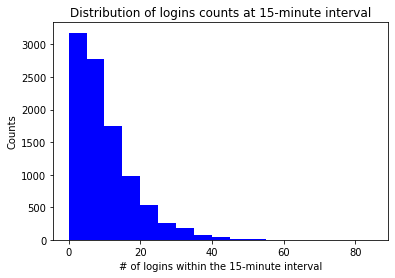

In [12]:
# understand the basic distribution of login counts at 15-minute intervals
logins['count'].plot(kind='hist',bins=np.arange(0,90,5),color='blue',title="Distribution of logins counts at 15-minute interval");
plt.xlabel("# of logins within the 15-minute interval");
plt.ylabel("Counts");

## 3.2 Plot the time series

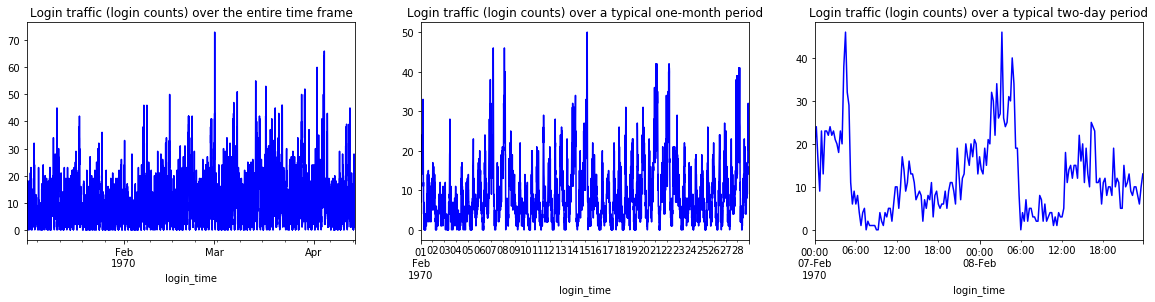

In [14]:
# plot the time series data
plt.figure(figsize=(20,4));
ax1 = plt.subplot(1,3,1)
logins.plot(ax=ax1,color='blue',title='Login traffic (login counts) over the entire time frame',legend=False);
ax2 = plt.subplot(1,3,2)
logins['1970-02'].plot(ax=ax2,color='blue',title='Login traffic (login counts) over a typical one-month period',legend=False);
ax3 = plt.subplot(1,3,3)
logins['1970-02-07':'1970-02-08'].plot(ax=ax3,color='blue', title='Login traffic (login counts) over a typical two-day period',legend=False);

The time series trends of login counts at 15-minute interval shows a clear daily cycle and a weekly cycle on top of that, which we will take a deeper look at.



## 3.3 Cyclic patterns

In [18]:
# extract time features from datetime index
logins['month'] = logins.index.month
logins['week'] = logins.index.week
logins['day'] = logins.index.day
logins['hour'] = logins.index.hour
logins['dayofweek'] = logins.index.dayofweek
print(logins.head())
print(logins.tail())

                     count  month  week  day  hour  dayofweek
login_time                                                   
1970-01-01 20:00:00      2      1     1    1    20          3
1970-01-01 20:15:00      6      1     1    1    20          3
1970-01-01 20:30:00      9      1     1    1    20          3
1970-01-01 20:45:00      7      1     1    1    20          3
1970-01-01 21:00:00      1      1     1    1    21          3
                     count  month  week  day  hour  dayofweek
login_time                                                   
1970-04-13 17:45:00      5      4    16   13    17          0
1970-04-13 18:00:00      5      4    16   13    18          0
1970-04-13 18:15:00      2      4    16   13    18          0
1970-04-13 18:30:00      7      4    16   13    18          0
1970-04-13 18:45:00      6      4    16   13    18          0


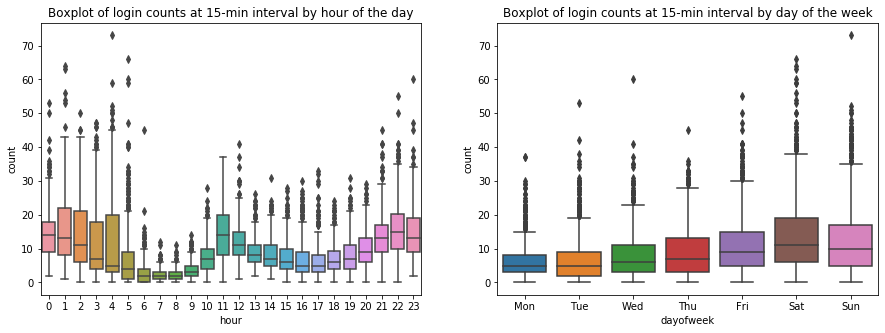

In [19]:
# boxplot showing daily and weekly cycles

plt.figure(figsize=(15,5))
# daily cycles
ax1 = plt.subplot(1,2,1)
sns.boxplot(x='hour',y='count',data=logins,ax=ax1);
ax1.set_title('Boxplot of login counts at 15-min interval by hour of the day');
# weekly cycles
ax2 = plt.subplot(1,2,2)
sns.boxplot(x='dayofweek',y='count',data=logins,ax=ax2);
ax2.set_title('Boxplot of login counts at 15-min interval by day of the week');
ax2.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

 As shown, the counts show clear cyclic patterns:
1) daily pattern: the login count at 15-minute intervals starts off the day from its daily lowest in the early morning (6am-9am), bounces up to its first spike around lunch time (11am-12pm), followed by a gradual decline in the afternoon till 5pm; it gradually rises back up in the early evening and reaches its second peak in late evening to midnight (21pm-2am). The high counts also show wider distributions in general.
2) weekly pattern: the login count at 15-minute intervals sees the lowest on Monday, and gradually ramps up throughout the week, and reaches its peak on weekends. Login counts on Saturday are slightly higher than those on Sunday. Again, the higher counts are associated with wider distributions.

However, it's possible that the daily pattern differs between weekdays and weekends. Therefore, a 2D heatmap might reveal more insights on the interplay between daily cycles and weekly cycles.

dayofweek          0          1
hour                           
0           8.850000  10.839286
1           6.900000  10.107143
2           5.200000   7.035714
3           3.933333   3.535714
4           3.433333   2.660714
5           2.016667   2.017857
6           1.100000   0.821429
7           1.850000   1.142857
8           2.450000   1.571429
9           4.266667   4.321429
10          9.300000   8.553571
11         15.783333  18.125000
12         12.033333  12.678571
13          7.100000   6.446429
14          5.616667   5.517857
15          4.883333   4.410714
16          4.150000   3.910714
17          3.966667   3.267857
18          4.450000   5.410714
19          4.678571   5.375000
20          6.714286   8.714286
21         10.803571  12.571429
22         10.910714  13.535714
23          9.500000  12.928571


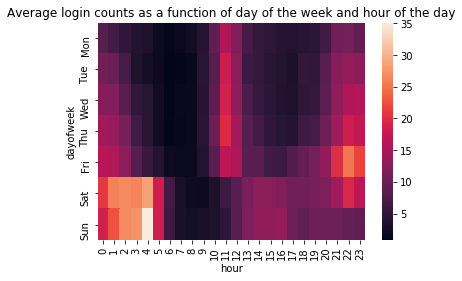

In [23]:
# pivot 'logins' dataframe by 'dayofweek' as the index and 'hour' as the column, average the login counts at the values
login_p = pd.pivot_table(logins, index='dayofweek',columns='hour',values='count',aggfunc='mean')
print(login_p.head(2).T)

# plot the heatmap
ax = sns.heatmap(login_p);
ax.set_title("Average login counts as a function of day of the week and hour of the day");
ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

## 3.4 Trends over time

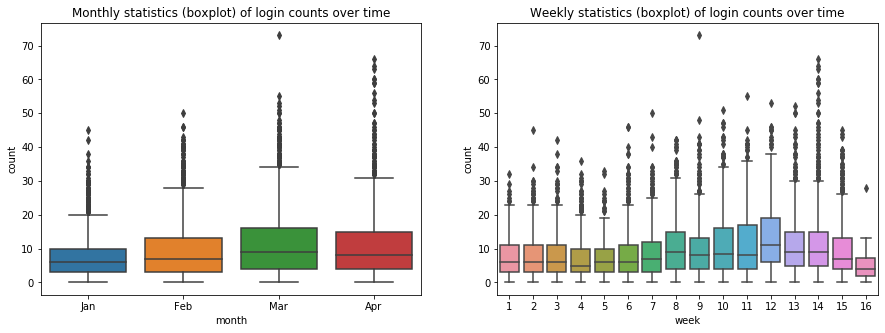

In [25]:
# boxplot showing trends over time
plt.figure(figsize=(15,5))
# monthly statistics over time
ax1 = plt.subplot(1,2,1)
sns.boxplot(x='month',y='count',data=logins,ax=ax1);
ax1.set_title('Monthly statistics (boxplot) of login counts over time');
ax1.set_xticklabels(['Jan','Feb','Mar','Apr']);
# weekly statistics over time
ax2 = plt.subplot(1,2,2)
sns.boxplot(x='week',y='count',data=logins,ax=ax2);
ax2.set_title('Weekly statistics (boxplot) of login counts over time');

As shown, the login counts at 15-minute interval rise from January to March, followed by a decline in April. This trend over time is even more promininent when looking at the chart of weekly statistics of login counts.

The continuous rise in login counts from January to early March (week 1 to 12) shows a good sign of improving user engagement. However, the significant decline in week 15 & 16 (April) might indicate some serious problems, which definitely worth looking into.

# Part 2. Experiment and metrics design¶


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.



## 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?


##### First we need to find two groups of driver partners:
Group A): driver partners exclusive to city 'Gotham'

Group B): driver partners exclusive to city 'Metropolis'

##### My proposed key measure of success is:

1) the increased time spend in city 'Metropolis' by group A drivers (drivers associated with 'Gotham')

2) the increased time spend in city 'Gotham' by group B drivers (drivers associated with 'Metropolis')

We should track both groups because this proposed experiment might only have an effect on one of the groups.

##### Reasons:

1) this is an effective measure of whether driver partners are serving both cities or not:

    If drivers are serving both cities, they must spend time in both cities. For drivers previously exclusive to 'Gotham', they must spend more time in 'Metropolis' if they start to serve both cities, and vise versa.

2) when compared with other effective measures, this is among the easiest-to-collect metric, because it doesn't require additional infrastructures, equipments and policies to be implemented:

Assuming that the toll stations at the two-way toll bridge already keep a record of the toll amount, the driver/vehicle identify (driver ID, or vehicle license plate) and the corresponding timestamp everytime a toll is collected. We can easily compute the time a particular driver spend in a city by looking at the two adjacent toll collection entries of that driver (e.g.: subtracting the timestamp of toll collected in direction 'Gotham'--> 'Metropolis' from the next timestamp of toll collected in direction 'Metropolis'-->'Gotham' is the time the driver spend in city 'Metropolis' during that trip.

Therefore, this metric can be obtained based on the existing recording system at the toll bridge. Whereas other more direct measures such as tracking picking up and dropping off locations of driver partners will require installing additional location-tracking devices, and drivers' agreement on participation (being tracked).

## 2 Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

##### a) how you will implement the experiment?

First, based on the current toll records, we need to devide the driver partners into two groups proposed above by analyzing the time drivers spent in each city. In particular, we are interested in drivers currently mostly exclusive to city 'Gotham' as group A, and driver currently mostly exclusive to city 'Metropolis' as group B.
note: There could be a third group (group C) for drivers currently already serving both cities, depending on the scope of the experiment and the resources (money and labor) available to the experiment.

Secondly, for each group, we will split the group in half randomly. Reach out to the picked drivers in the group (e.g. when they pass the toll-bridge) and provide them with the toll reimbursement offer.

Lastly, for each group, we look at the toll records for all drivers in the group after half of them (the experiment) have been given the offer, and compare their statistics (the time drivers spend in their non-associated city) to see if the difference between the experient and the control is statistically significant.

##### b) what statistical test(s) you will conduct to verify the significance of the observation?

By dividing each group of drivers randomly in half, we can conduct a A/B test. This allows us to evaluate the key metric for each group by comparing the experiment vs control with the toll reimbursement offer as the only variable. In particular, this allows a comparison within exactly the same timeframe, as workday vs. weekend and weather condition all have an impact on drivers activity.

After enough data are collected, we will compute a two-sample t statistic to determine if the average time drivers spend in their non-associated city is significant different between the experiment vs control.

Significance level: 0.05 (or even 0.01)

Null hypothesis is:$$H_0: \mu_(experiment) - \mu_(control) = 0$$
Alternative hypothesis is:$$H_a: \mu_(experiment) - \mu_(control) > 0$$
We will compute the t-statistics and use $t$ table to find the p-value and draw conclusion.

##### c) how you would interpret the results and provide recommendations to the city operations team along with any caveats:

The interpretation depends on the p-value concluded from the above t-tests for each group.
If p-value is smaller than the significance level for both group A and B, the experiment and the results along with the confidence level and the power of the statistical tests should be present to the city operation team, so they can make an informed decision on whether to implement the toll reimbursement strategy or not.

The potential caveats are:

The difference is only significant during weekdays, but not on weekends:

This is entirely possible given that, there is reasonable activity in both cities on weekends, and the drivers have enough riders by staying only in one city.

The difference is only significant in one group:

This is also possible. For instance, city 'Gotham' is mostly active at night. Without bridge toll, drivers associated with city 'Gotham' might be willing to go to city 'Metropolis' during the day for more riders, resulting in a significant difference in this group;

But city 'Metropolis' is mostly active during the day, and drivers associated with city 'Metropolis' might not be willing to serve city 'Gotham' at night, especially if they prefer to stay home with family during night time. This will result in non-significant difference in this group.

# Part 3. Predictive modeling

## 1. Import data

In [26]:
user = pd.read_json('ultimate_data_challenge.json')

In [27]:
user.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [28]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [30]:
user.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

As shown, there are three columns containing missing information, one being categorical columns and two being numercal columns. These missing value should be dealt with.

In addition, there are two columns containing date-related records. These should be converted to datetime format.

## 2. Data wrangling

In [33]:
# convert date-related columns to datetime format
user['last_trip_date'] = pd.to_datetime(user.last_trip_date, format='%Y-%m-%d')
user['signup_date'] = pd.to_datetime(user.signup_date, format='%Y-%m-%d')

In [34]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [35]:
#fill in missing values as 'N.A.' for the categorical column 'phone'
user.phone = user.phone.fillna('N.A.')

In [37]:
user.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

note: the missing values of columns 'avg_rating_of_driver' and 'avg_rating_by_driver' will be imputed later

In [36]:
# check on categorical column
print("---\n",user.city.value_counts(dropna=False))
print("---\n",user.phone.value_counts(dropna=False))
print("---\n",user.ultimate_black_user.value_counts(dropna=False))

---
 Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64
---
 iPhone     34582
Android    15022
N.A.         396
Name: phone, dtype: int64
---
 False    31146
True     18854
Name: ultimate_black_user, dtype: int64


All catogorical columns are looking fine. 

In [38]:
# using describe() function for checking numerical columns
user.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [39]:
# check on datetime columns
print("---\n", user['last_trip_date'].describe())
print("---\n", user['signup_date'].describe())

assert len(user[user.last_trip_date < user.signup_date]) == 0

---
 count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object
---
 count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object


As the 'signup_date' is between '2014-01-01 00:00:00' and '2014-01-31 00:00:00' i.e, all users belong to the cohort of January, 2014.

In addition, the latest time in the 'last_trip_date' column was '2014-07-01 00:00:00', therefore we assume the data was pulled right after '2014-07-01 00:00:00', i.e atleast six months after signup for this cohort of users signed up in January, 2014

## 3. Compute the fraction of users 'retained'


Since the data was pulled on 2014-07-01, therefore a user is considered 'retained' if the user took a trip within the 30 days prior to 2014-07-01.



In [40]:
# compute the cutoff time for determing user retention
cutoff = user.last_trip_date.max() - pd.Timedelta('30 days')
cutoff

Timestamp('2014-06-01 00:00:00')

In [41]:
# determine if a user is retained based on the cutoff time
user['retained'] = user.last_trip_date.apply(lambda x: True if x >= cutoff else False)

In [42]:
user.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [44]:
# compute the fraction of user retained
user.retained.sum()/len(user)*100

37.608000000000004


As shown, only 37.6% of all users signed up in January, 2014 are retained six month later.

##  Exploratory Data Analysis (EDA)

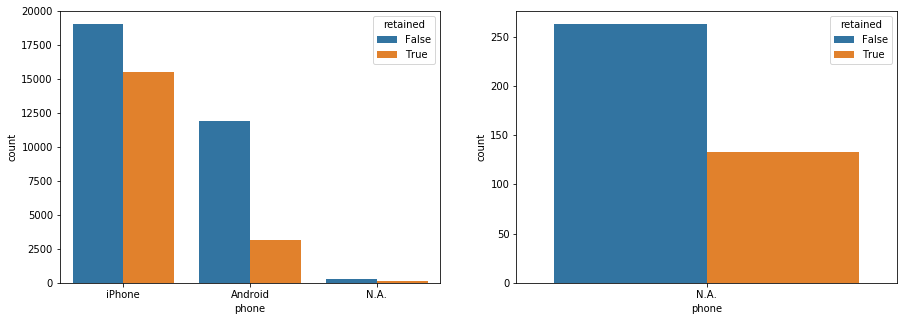

In [47]:
# correlation between 'retained' and 'phone'
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
sns.countplot(x='phone', data=user, hue='retained',ax=ax1);
ax2 = plt.subplot(1,2,2)
sns.countplot(x='phone', data=user[user.phone == 'N.A.'], hue='retained',ax=ax2);


As shown, user retention is strongly correlated to the type of phone used by the user:
iphone users show a much higher retention rate (44.9%) than Android users (20.9%), whereas for users with no phone informaiton available, the rate is in the middle (33.6%).

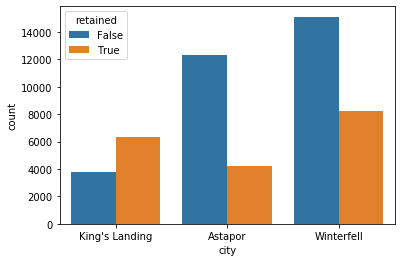

In [48]:
# correlation between 'retained' and 'city'
sns.countplot(x='city', data=user, hue='retained');

user retention is also strongly correlated to the city the user signed up in:
King's landing gives the highest retention rate among the three cities, whereas Astapor is the lowest.

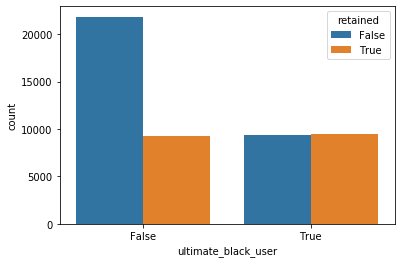

In [49]:
# correlation between 'retained' and 'city'
sns.countplot(x='ultimate_black_user', data=user, hue='retained');

 user retention also correlates to whether a user is an 'ultimate black user':
 
Ultimate black users have a higher retention rate than non ultimate black users.

## 4.2 Correlation of user retention with numerical columns


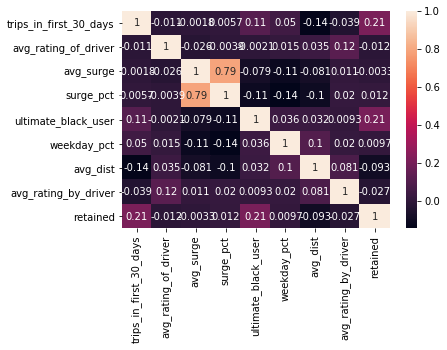

In [56]:
sns.heatmap(user.corr(),annot=True);

Among the numerical columns, 'trips_in_first_30_days' shows the most positive correlations whereas the 'avg_dist' shows the most negative correlations.

There are several numerical columns only showing minor correlations, including 'avg_rating_by_driver' and 'avg_rating_of_driver' columns. Therefore, we will simply use the median of those two columns to impute the missing values.

## 4.3 Correlation of user retention with datetime columns

signup_date
0    0.387984
1    0.376073
2    0.376645
3    0.360115
4    0.370533
5    0.380453
6    0.384687
Name: retained, dtype: float64


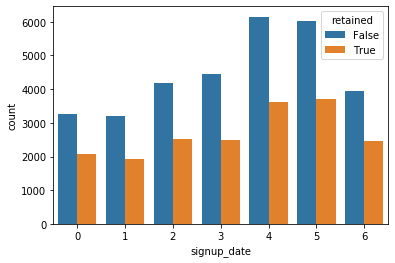

In [57]:
# correlation between 'retained' and 'day of the week' the user signed up
sns.countplot(x=user.signup_date.dt.dayofweek, data=user, hue='retained');
print(user.groupby(user.signup_date.dt.dayofweek)['retained'].mean())

signup_date
1    0.413005
2    0.377241
3    0.358766
4    0.374445
5    0.370746
Name: retained, dtype: float64


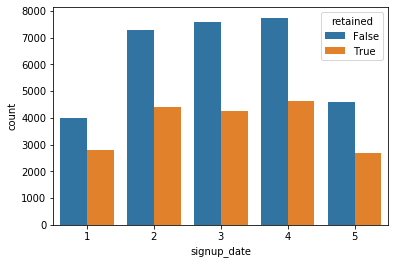

In [58]:
# correlation between 'retained' and 'week of the month' the user signed up
sns.countplot(x=user.signup_date.dt.week, data=user, hue='retained');
print(user.groupby(user.signup_date.dt.week)['retained'].mean())

# add 'signup_week' as a new feature and drop the original 'signup_date' column
user['signup_week'] = user.signup_date.dt.week.astype('category')
user = user.drop('signup_date',axis=1)

last_trip_date
0    0.438352
1    0.381611
2    0.328779
3    0.340780
4    0.359635
5    0.371874
6    0.389008
Name: retained, dtype: float64


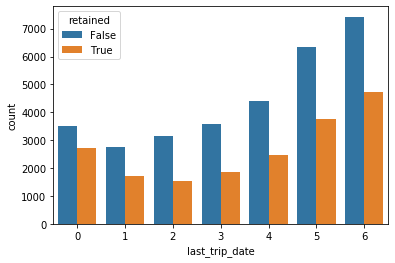

In [59]:
# correlation between 'retained' and 'day of the week' the user's last trip is
sns.countplot(x=user.last_trip_date.dt.dayofweek, data=user, hue='retained');
print(user.groupby(user.last_trip_date.dt.dayofweek)['retained'].mean())

# add 'lasttrip_dayofweek' as a new featue
user['lasttrip_dayofweek'] = user.last_trip_date.dt.dayofweek.astype('category')

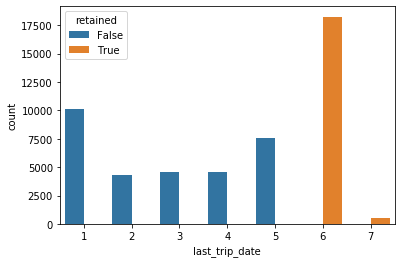

In [60]:
# correlation between 'retained' and the month the user's last trip is
sns.countplot(x=user.last_trip_date.dt.month, data=user, hue='retained');
# drop the original 'last_trip_date' column
user = user.drop('last_trip_date',axis=1)

As show, there is a minor correlation is observed between user retention and on which day of the week the user's last trip occurs, therefore this is added a new feature.

On the other hand, the user retention is totally correlated to the month of the last trip as expected, since the the 'retained' user is identified based on their last trip date being 2014-06-01 and after. Therefore, this feature is not added and the original 'last_trip_date' column is dropped.

## 5. Modeling

To predict user adoption of the product, four different classification algorithms are experimented:

    1.Linear Logistic Regression classification algorithm

    2.non-linear Support Vector Machine classification algorithm

    3.ensembles of tree-based Random Forest classification algorithm

    4.ensembles of tree-based Gradient Boosting classification algorithm

## 5.1 Importing required modules

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report

In [62]:
# impute missing values in 'avg_rating_by_driver' and 'avg_rating_of_driver' columns
user['avg_rating_by_driver'] = user.avg_rating_by_driver.fillna(user.avg_rating_by_driver.median())
user['avg_rating_of_driver'] = user.avg_rating_of_driver.fillna(user.avg_rating_of_driver.median())

In [63]:
user.isnull().sum()

city                      0
trips_in_first_30_days    0
avg_rating_of_driver      0
avg_surge                 0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
retained                  0
signup_week               0
lasttrip_dayofweek        0
dtype: int64

No null values

In [64]:
# extract features X and target variable y
X = pd.get_dummies(user.drop('retained',axis=1), drop_first=True)
y = user.retained

X.head(2)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,...,signup_week_2,signup_week_3,signup_week_4,signup_week_5,lasttrip_dayofweek_1,lasttrip_dayofweek_2,lasttrip_dayofweek_3,lasttrip_dayofweek_4,lasttrip_dayofweek_5,lasttrip_dayofweek_6
0,4,4.7,1.1,15.4,True,46.2,3.67,5.0,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,5.0,1.0,0.0,False,50.0,8.26,5.0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [65]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [67]:
# initiate the score table
index = ['LogisticRegression','SVC','RandomForestClassifier','GradientBoostingClassifier']
score_table = pd.DataFrame(index = index, columns= ['accuracy_train','f1_score_train','accuracy_test','f1_score_test'])

# define function for plotting the results
def compute_log_result(algo, pred_train, pred_test):
    """compute and log the performance for both training and test sets"""
    
    # compute the performance  
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    
    # log the performance
    score_table.loc[algo,:] = accuracy_train, f1_train, accuracy_test, f1_test
    
    # compute confusion matrix and print
    print("Classification results based on the testset:\n", classification_report(y_test, pred_test))

## 5.2 Prototyping with default parameters

In [70]:
# fit logistic regression model with default parameters

logit = Pipeline([('scaler', StandardScaler()),('logit',LogisticRegression())])
logit.fit(X_train, y_train)
pred_train = logit.predict(X_train)
pred_test = logit.predict(X_test)

# logging of model performance
compute_log_result("LogisticRegression", pred_train, pred_test)

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.74      0.85      0.79      7799
        True       0.67      0.50      0.57      4701

    accuracy                           0.72     12500
   macro avg       0.70      0.67      0.68     12500
weighted avg       0.71      0.72      0.71     12500



In [71]:
# fit support vector machine model with default parameters

svc = Pipeline([('scaler', StandardScaler()),('svc', SVC())])
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

# logging of model performance
compute_log_result("SVC", pred_train, pred_test)

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.78      0.86      0.82      7799
        True       0.72      0.59      0.65      4701

    accuracy                           0.76     12500
   macro avg       0.75      0.72      0.73     12500
weighted avg       0.76      0.76      0.75     12500



In [72]:
# fit random forest model with default parameters

rfc = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier(class_weight='balanced'))]) # set class_weight='balanced' to adjust for the imbalanced classes
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

compute_log_result("RandomForestClassifier", pred_train, pred_test)

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.80      0.85      0.82      7799
        True       0.72      0.64      0.68      4701

    accuracy                           0.77     12500
   macro avg       0.76      0.75      0.75     12500
weighted avg       0.77      0.77      0.77     12500



In [73]:
# fit gradientboosting model with default parameters

gbc = Pipeline([('scaler', StandardScaler()),('gbc', GradientBoostingClassifier())]) # set class_weight='balanced' to adjust for the imbalanced classes
gbc.fit(X_train, y_train)
pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)

compute_log_result("GradientBoostingClassifier", pred_train, pred_test)

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.81      0.86      0.84      7799
        True       0.74      0.67      0.70      4701

    accuracy                           0.79     12500
   macro avg       0.78      0.77      0.77     12500
weighted avg       0.79      0.79      0.79     12500



In [74]:
print(score_table)

                           accuracy_train f1_score_train accuracy_test  \
LogisticRegression               0.722347       0.576851       0.71928   
SVC                              0.780533       0.677912       0.75896   
RandomForestClassifier           0.999813       0.999752       0.77272   
GradientBoostingClassifier       0.788507       0.702992       0.78888   

                           f1_score_test  
LogisticRegression              0.570659  
SVC                             0.647066  
RandomForestClassifier          0.680822  
GradientBoostingClassifier      0.704843  


## 5.3 Optimization

With the default parameters, GradientBoostingClassifier gives the best performance among the three. Therefore, parameter tuning of the GradientBoostingClassifier model is further performed using gridsearch cross validation.

In [75]:
# Grid search optimization of GradientBoostingClassifier

# Grid search of parameters n_estimators and max_features to improve GradientBoostingClassifer model
parameters = {'gbc__n_estimators': np.arange(500,1000,100), 'gbc__max_features':[None,'sqrt','log2']}
gbc_cv = GridSearchCV(gbc, parameters, scoring='accuracy', cv=5)
gbc_cv.fit(X_train, y_train)
print('Best parameters:', gbc_cv.best_params_)
print('Corresponding accuracy score:', gbc_cv.best_score_)

KeyboardInterrupt: 

In [ ]:
# updated GradientBoostingClassifier model with the optimized parameter
gbc = Pipeline([('scaler', StandardScaler()),('gbc', GradientBoostingClassifier(n_estimators=700, max_features='sqrt'))])
gbc.fit(X_train, y_train)
pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)

compute_log_result("GradientBoostingClassifier", pred_train, pred_test)

In [ ]:
# final results
print(score_table.loc['GradientBoostingClassifier'])

# feature importance ranking from the optimized GradientBoostingClassifier 
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbc.named_steps.gbc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

As shown, the optimized GradientBoostingClassifier gives the best accuracy score and F1 score among all. The feature ranking from the optimized classifier suggests that athe percent of weekday trips('weekday_pct'), trips taken in the first 30 days of signing up ('trips_in_first_30_days') and average trip distance ('avg_dist') are the top three factors indicating user retention after 6 month of signing up.



## Client recommendation

To understand and improve long-term rider retention:

1) Regular marketing email/outreach to users who take trips of intermediate distances, having the majority of their trips during weekdays, more than 2 trips during the first 30 days, and at least one trip of surge pricing, to make sure those who have needs and are likely to retain will indeed retain without dropping off.
2) Have more marketing campaign and maybe consider offering discount/coupon/incentives in cities 'Winterfell' and 'Astapor' as those two cities see a much lower user retention rate than city 'King's landing'.

Further investigation on why King's landing is much more successful at retaining users might provide valuable insights.

3) Investigate into why Android phone users show a significantly lower retention rate than iphone users. If part of the service involves the mobile app, this could suggest that the Android app might have bugs, or at least is not very user friendly.